In [1]:
Student_1 = '邓希尧' #@param {type:"string"}  Name of student 1
Student_2 = '' #@param {type:"string"}  Name of student 2
Student_3 = '' #@param {type:"string"}  Name of student 3
Student_4 = '' #@param {type:"string"}  Name of student 4
print(Student_1)

邓希尧


# Overview

This is the skeleton code file for the EEC4400 assignment. Replace the `XX`. in the name of this Jupyter notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this Jupyter notebook section by section). At the end, the entire Jupyter notebook should generate all the required results and execute without error.

The text above the blank cells provides information on the functionality that needs to be implemented. You need to write Python code at places indicated by `[WriteCode]`

## Install and Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
import time
import numpy as np
import random
from collections import deque

import gymnasium as gym

# Background

## Environment Exploration: Cart-Pole

The **Cart-Pole environment** is a classic reinforcement learning problem where a pole is attached by an un-actuated joint to a cart. The cart moves along a frictionless track, and the goal is to balance the pole upright by applying forces to move the cart left or right.

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" width="400">

Below is a breakdown of the base Cart-Pole environment:


#### - **Observation Space (*s*)**
The observation is represented as a `ndarray` of shape `(4,)`, corresponding to:
- **Cart Position**: Horizontal location of the cart.
- **Cart Velocity**: Speed of the cart along the track.
- **Pole Angle**: Angular position of the pole relative to vertical.
- **Pole Angular Velocity**: Speed at which the pole angle changes.

The observations are initialized with uniformly random values in the range `(-0.05, 0.05)`.


#### - **Action Space (*a*)**
The action is a discrete value (`0` or `1`) indicating the direction of the force applied to the cart:
- `0`: Push the cart to the left.
- `1`: Push the cart to the right.



#### - **Reward Function (*r*)**
The agent receives a reward of `+1` for each time step it successfully keeps the pole upright. The maximum achievable reward in a single episode is `500`.

#### - **Episode Termination (*isDone*)**
An episode ends if any of the following conditions occur:
1. **Pole Angle** exceeds `±12°`.
2. **Cart Position** exceeds `±2.4` (the cart reaches the edge of the track).
3. **Truncation**: The episode reaches the maximum length of `500 steps`.

## Getting Familiar with Basic Gymnasium Usage

Let's observe how to interact with a Gymnasium environment.

The classic “agent-environment loop” pictured below is a simplified representation of reinforcement learning that Gymnasium implements.

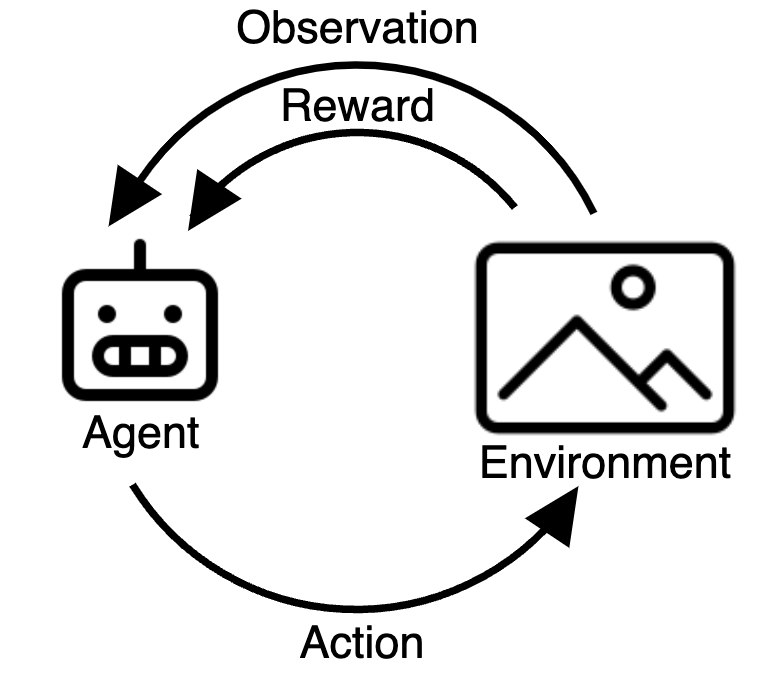

The following section represents a simple episode of this loop, we will:

1. Import the base Cart-Pole environment from the gymnasium library and explore its functionality.

2. Apply modifications to make the environment more challenging by adjusting the pole's dynamics and introducing stochastic forces.

3. Sample random actions to control the cart-pole.

These steps will help us understand how the environment behaves under different conditions and prepare us for implementing reinforcement learning agents in later sections.



In [3]:
import warnings
warnings.filterwarnings('ignore')

# Import and Explore the Environment
print("\n--- Exploring the Base Environment ---")
env = gym.make("CartPole-v1")
observation, info = env.reset()

# Print information about the environment
print(f"Initial Observation: {observation}") #小车位置 (Cart Position)小车速度 (Cart Velocity)杆子角度 (Pole Angle)杆尖速度 (Pole Angular Velocity)
print(f"Action Space: {env.action_space}")  # Discrete actions: 0 (left), 1 (right)
print(f"Observation Space: {env.observation_space}")  # State variables: cart position, etc.


--- Exploring the Base Environment ---
Initial Observation: [ 0.01559921  0.04722822 -0.00374018 -0.01577418]
Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


# Define Helper Functions

## Plotting Functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# --- 设置一个美观的绘图风格 ---
# 'seaborn-v0_8-whitegrid' 是一个非常流行的风格，带有网格，看起来很清爽
plt.style.use('seaborn-v0_8-whitegrid')


def plot_eval_rwd_mean(eval_mean_list):
    """
    绘制评估阶段的平均奖励随时间变化的曲线。

    Args:
        eval_mean_list (list or np.ndarray): 包含每次评估的平均奖励的列表。
    """
    # 创建一个图形和坐标轴，设置图形大小
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # x轴坐标就是评估的次数
    x_axis = range(len(eval_mean_list))
    
    # 绘制曲线
    ax.plot(x_axis, eval_mean_list, 
            color='dodgerblue',          # 使用一种好看的蓝色
            marker='o',                  # 在每个数据点上加个圆圈标记
            linestyle='-',               # 使用实线连接
            linewidth=2,                 # 线条宽度
            markersize=5,                # 标记大小
            label='Mean Reward')         # 图例标签
            
    # 设置标题和坐标轴标签，并增加字体大小
    ax.set_title('Evaluation Reward Mean Over Time', fontsize=16)
    ax.set_xlabel('Evaluation Step', fontsize=12)
    ax.set_ylabel('Mean Reward', fontsize=12)
    
    # 显示图例
    ax.legend()
    
    # 显示图形
    plt.tight_layout()  # 调整布局以防止标签重叠
    plt.show()


def plot_eval_rwd_var(eval_var_list):
    """
    绘制评估阶段的奖励方差随时间变化的曲线。

    Args:
        eval_var_list (list or np.ndarray): 包含每次评估的奖励方差的列表。
    """
    # 创建一个图形和坐标轴
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # x轴坐标
    x_axis = range(len(eval_var_list))
    
    # 绘制曲线
    ax.plot(x_axis, eval_var_list, 
            color='forestgreen',         # 使用绿色
            marker='s',                  # 使用方形标记
            linestyle='--',              # 使用虚线
            linewidth=2,
            markersize=5,
            label='Reward Variance')
            
    # 设置标题和标签
    ax.set_title('Evaluation Reward Variance Over Time', fontsize=16)
    ax.set_xlabel('Evaluation Step', fontsize=12)
    ax.set_ylabel('Reward Variance', fontsize=12)
    
    # 显示图例
    ax.legend()
    
    # 显示图形
    plt.tight_layout()
    plt.show()


def plot_smoothed_training_rwd(train_rwd_list, window_size=20):
    """
    使用移动平均法绘制平滑后的训练奖励曲线。
    同时将原始的、未平滑的奖励作为背景，以提供对比。

    Args:
        train_rwd_list (list or np.ndarray): 包含每个训练回合总奖励的列表。
        window_size (int): 移动平均的窗口大小。
    """
    if len(train_rwd_list) < window_size:
        print(f"Warning: train_rwd_list has fewer elements ({len(train_rwd_list)}) than window_size ({window_size})." 
              " Cannot compute moving average.")
        return

    # 创建一个图形和坐标轴
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 1. 绘制原始的训练奖励，使用较浅的颜色和透明度作为背景
    ax.plot(train_rwd_list, 
            color='lightgray', 
            alpha=0.6, 
            label='Raw Reward per Episode')
            
    # 2. 计算移动平均值
    # np.convolve 是一个高效计算移动平均的方法
    # mode='valid' 确保我们只在窗口完全覆盖数据时才计算平均值
    smoothed_rewards = np.convolve(train_rwd_list, np.ones(window_size)/window_size, mode='valid')
    
    # 3. 绘制平滑后的奖励曲线，使用醒目的颜色
    # 注意：平滑后的数据点数会减少，x轴需要对齐
    smoothed_x_axis = np.arange(window_size - 1, len(train_rwd_list))
    ax.plot(smoothed_x_axis, smoothed_rewards, 
            color='crimson',             # 使用深红色
            linewidth=2.5, 
            label=f'Smoothed Reward (Window Size = {window_size})')
            
    # 设置标题和标签
    ax.set_title('Smoothed Training Rewards Over Episodes', fontsize=16)
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Total Reward', fontsize=12)
    
    # 显示图例
    ax.legend()
    
    # 显示图形
    plt.tight_layout()
    plt.show()



--- Plotting Evaluation Mean Reward ---


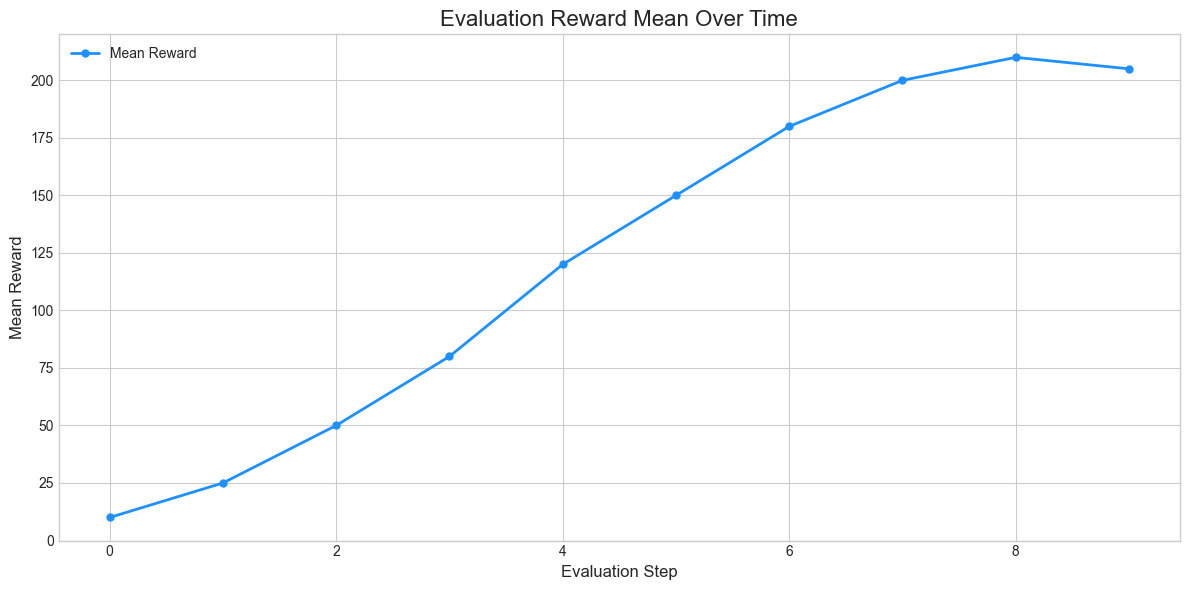


--- Plotting Evaluation Reward Variance ---


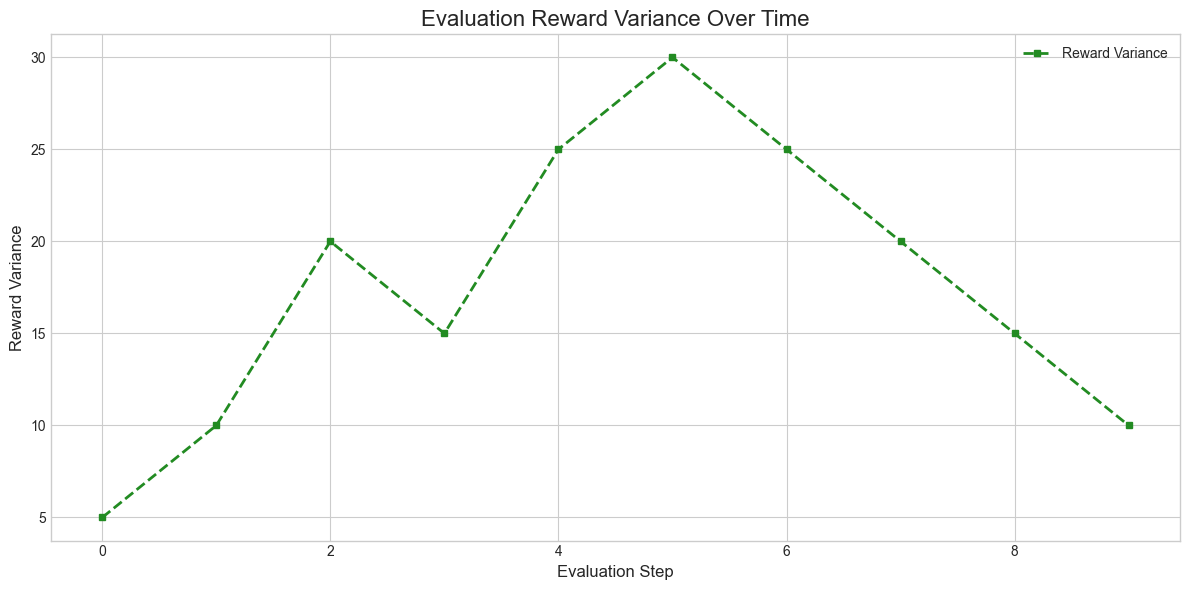


--- Plotting Smoothed Training Reward ---


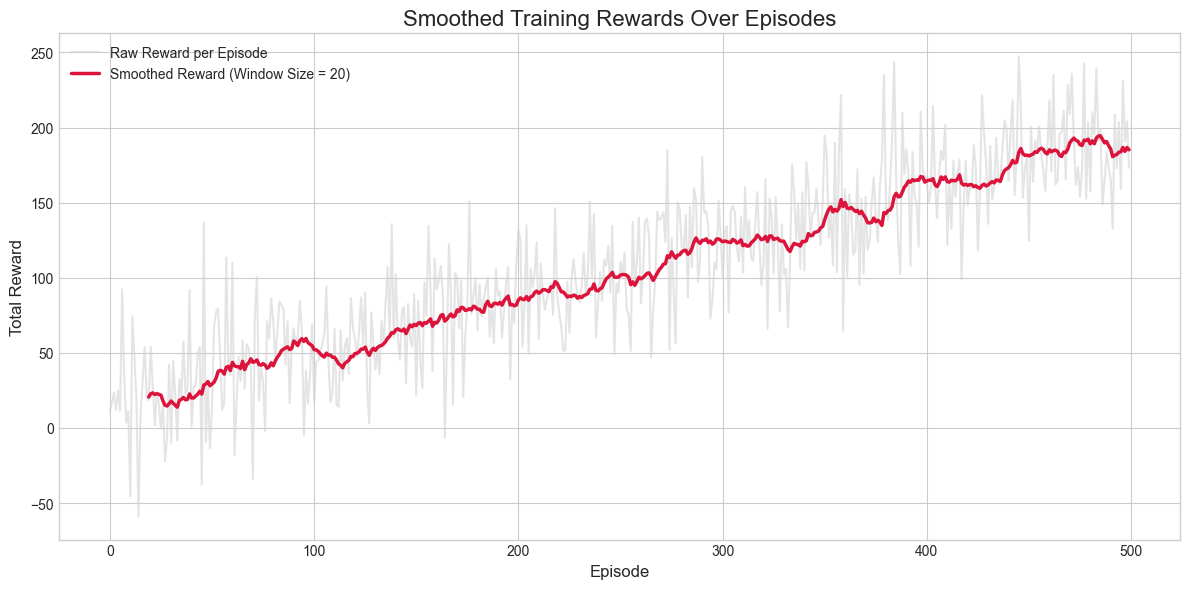

In [5]:
# --- 测试绘图函数 ---
    # 生成一些假的示例数据
    # 评估数据（通常点比较少）
fake_eval_mean = np.array([10, 25, 50, 80, 120, 150, 180, 200, 210, 205])
fake_eval_var = np.array([5, 10, 20, 15, 25, 30, 25, 20, 15, 10])

# 训练数据（通常点很多，波动大）
base_rewards = np.linspace(10, 200, 500)
noise = np.random.normal(0, 30, 500)
fake_training_rewards = base_rewards + noise

print("--- Plotting Evaluation Mean Reward ---")
plot_eval_rwd_mean(fake_eval_mean)

print("\n--- Plotting Evaluation Reward Variance ---")
plot_eval_rwd_var(fake_eval_var)

print("\n--- Plotting Smoothed Training Reward ---")
plot_smoothed_training_rwd(fake_training_rewards, window_size=20)

## Evaluation Function

Evaluate the learnt policy by running 5 evaluation episodes and computing the average and variance of rewards collected.

In [6]:
def evaluation(model, max_timesteps=500):
    eval_env = gym.make("CartPole-v1")
    state_size = eval_env.observation_space.shape[0] # Number of observations (CartPole)
    action_size = eval_env.action_space.n            # Number of possible actions
    eval_reward = []

    for i in range (5):
        round_reward = 0
        state, _ = eval_env.reset()
        state = np.reshape(state, [1, state_size])

        for i in range(max_timesteps):
            action = np.argmax(model.predict(state, verbose=0)[0])               #verbose=0 to 用来设置日志静默模式(其他可选值为1进度条模式，2精简日志模式)                                                                                    
            next_state, reward, terminated, truncated, _ = eval_env.step(action) #argmax返回最大值的索引
            next_state = np.reshape(next_state, [1, state_size])

            round_reward += reward
            state = next_state

            if terminated or truncated:
                eval_reward.append(round_reward)
                break

    eval_env.close()

    eval_reward_mean = np.sum(eval_reward)/len(eval_reward)
    eval_reward_var = np.var(eval_reward)

    return eval_reward_mean, eval_reward_var

# Setting up Tensorboard


In [7]:
# def get_run_logdir(k):
#     root_logdir = os.path.join(os.curdir, "eec4400_logs", k) #curdir 获取当前工作目录
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") #strftime() 根据指定的格式，将当前时间格式化成一个字符串
#     return os.path.join(root_logdir, run_id)
def get_run_logdir(k):
    # 使用 os.getcwd() 获取当前工作目录的实际路径，而不是 os.curdir (返回 '.')
    root_logdir = os.path.join(os.getcwd(), "eec4400_logs", k)
    
    # 确保所有父目录都存在
    os.makedirs(root_logdir, exist_ok=True)
    
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    logdir = os.path.join(root_logdir, run_id)
    
    # 确保最终的运行目录也存在
    os.makedirs(logdir, exist_ok=True)
    
    # 转换为绝对路径并规范化
    logdir = os.path.abspath(logdir)
    
    # 验证目录确实存在
    if not os.path.isdir(logdir):
        raise ValueError(f"无法创建或访问目录: {logdir}")
    
    print(f"TensorBoard log directory: {logdir}")
    return logdir

# Initialize Parameters

In [8]:
# Use the following set of NN hyperparameters for ALL FOUR baseline policies
lr =  0.00025        #@param {type:"number"}               # learning rate
epoch =  1     #@param {type:"number"}               # epochs
episode = 50  #@param {type:"number"}               # episodes

epsilon = 1           #@param {type:"number"}     # Starting exploration rate
epsilon_min = 0.01    #@param {type:"number"}     # Exploration rate min
epsilon_decay = 0.995     #@param {type:"number"}     # Exploration rate decay

gamma = 0.99          #@param {type:"number"}     # Agent discount factor

# Use the following set of NN hyperparameters for Naive DQN, DQN and DDQN policies
ba =  32       #@param {type:"number"}               # batch_size

# Use the following set of RL hyperparameters for DQN and DDQN policies
target_update_freq = 100 # @param {type:"number"}    # Target network update frequency


# Q-Network - Baseline

## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

The training of Q-Network does NOT rely on a Replay Buffer.


In [9]:
# Q-Network Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...
from keras.optimizers import Adam


# Define the Q-network
model = Sequential()

# [WriteCode]
# model.add(...
# 添加网络层
model.add(Dense(64, input_dim=4, activation='relu'))  # 输入层：4个状态特征
model.add(Dense(64, activation='relu'))                # 隐藏层
model.add(Dense(2, activation='linear'))               # 输出层：2个动作的Q值


# Compile the model
# [WriteCode]
# 编译模型
model.compile(loss='mse', optimizer=Adam(learning_rate=lr))


# Print the model summary
# [WriteCode]
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,610 (18.01 KB)

 Trainable params: 4,610 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

## Set Up Env and Train the Policy

In [10]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []


# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "q_net_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# For timing training
total_training_time = 0

# 检查模型是否已定义
if 'model' not in globals() or model is None:
    raise ValueError("模型未定义！请先运行模型定义cell。")

# 检查模型是否有层
if len(model.layers) == 0:
    raise ValueError("模型没有层！请先运行模型定义cell并确保添加了层。")

print(f"模型已定义，包含 {len(model.layers)} 层")

TensorBoard log directory: c:\Users\roycl\Desktop\EEC4400\eec4400_logs\q_net_baseline\run_2025_11_06-16_04_27
模型已定义，包含 3 层


In [11]:
for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            # pass # remove pass and use 2 lines below
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # Train model using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
        # [WriteCode]

        # Hints:

        # 1. Compute target Q-values:
        # - If done, Q-target = reward (no future reward)
        # - Otherwise, Q-target = reward + gamma * max(Q(next_state, a))
        if done:
            # If done, Q-target = reward (no future reward)
            target_q = reward
        else:
            # Otherwise, Q-target = reward + gamma * max(Q(next_state, a))
            next_q_values = model.predict(next_state, verbose=0)[0]
            target_q = reward + gamma * np.max(next_q_values)
        

        # 2. Predict current Q-values for state
        # Update only the Q-value for the taken action
        q_values = model.predict(state, verbose=0)[0]
        q_values[action] = target_q

        # 3. Fit the model:
        # - Inputs: state
        # - Targets: updated Q-values (with action Q-value replaced by computed target)
        # 移除 TensorBoard 回调以提高速度，只在每个 episode 结束时记录一次
        model.fit(state, q_values.reshape(1, -1), epochs=epoch, verbose=0)

        state = next_state
        total_reward += reward

        if done:
            break

    # record end time and log the training time
    end = time.time()
    total_training_time += end - start
    
    # Update exploration rate (每个episode更新一次，而不是每个时间步)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    # Evaluation
    # [WriteCode]
    # 暂时跳过评估以提高速度，只记录训练奖励
    eval_reward_mean, eval_reward_var = evaluation(model, max_timesteps=500)

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}"
       f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
       f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
    if eval_reward_mean > 500: # [Modify this threshold as needed]
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break 

# evaluate average training time per episode
print(f"Training time: {total_training_time/(ep + 1):.4f} seconds per episode")

env.close()


Episode 1/50 | Ep. Total Reward: 32.0 | Epsilon : 0.995 | Eval Rwd Mean: 9.20 | Eval Rwd Var: 0.16
Episode 2/50 | Ep. Total Reward: 17.0 | Epsilon : 0.990 | Eval Rwd Mean: 9.20 | Eval Rwd Var: 0.56
Episode 3/50 | Ep. Total Reward: 13.0 | Epsilon : 0.985 | Eval Rwd Mean: 9.40 | Eval Rwd Var: 0.64
Episode 4/50 | Ep. Total Reward: 14.0 | Epsilon : 0.980 | Eval Rwd Mean: 13.20 | Eval Rwd Var: 35.76
Episode 5/50 | Ep. Total Reward: 19.0 | Epsilon : 0.975 | Eval Rwd Mean: 14.40 | Eval Rwd Var: 44.64
Episode 6/50 | Ep. Total Reward: 12.0 | Epsilon : 0.970 | Eval Rwd Mean: 9.20 | Eval Rwd Var: 0.56
Episode 7/50 | Ep. Total Reward: 12.0 | Epsilon : 0.966 | Eval Rwd Mean: 12.80 | Eval Rwd Var: 31.36
Episode 8/50 | Ep. Total Reward: 47.0 | Epsilon : 0.961 | Eval Rwd Mean: 25.20 | Eval Rwd Var: 809.76
Episode 9/50 | Ep. Total Reward: 12.0 | Epsilon : 0.956 | Eval Rwd Mean: 49.20 | Eval Rwd Var: 981.36
Episode 10/50 | Ep. Total Reward: 28.0 | Epsilon : 0.951 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.

## Plot Results

--- Plotting Results for Q-Network Baseline Model ---


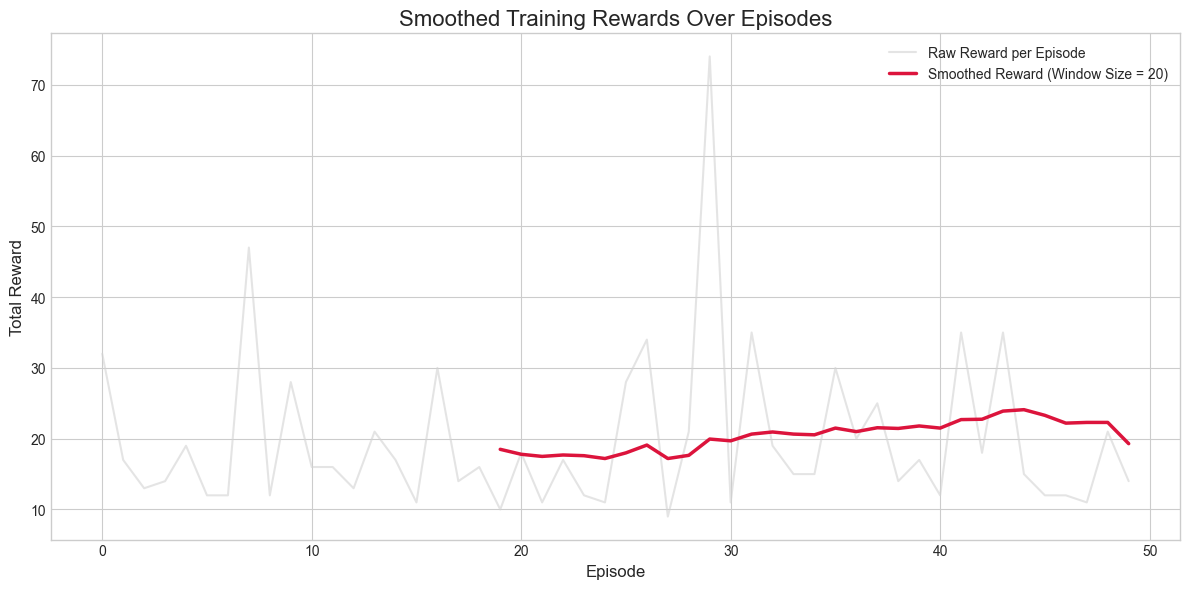

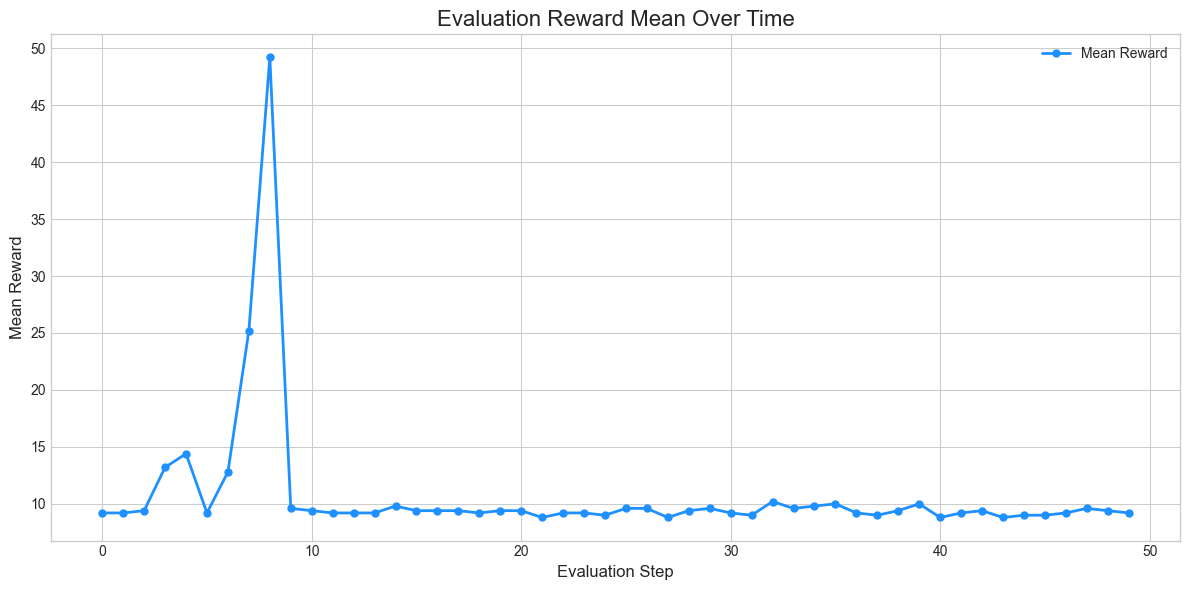

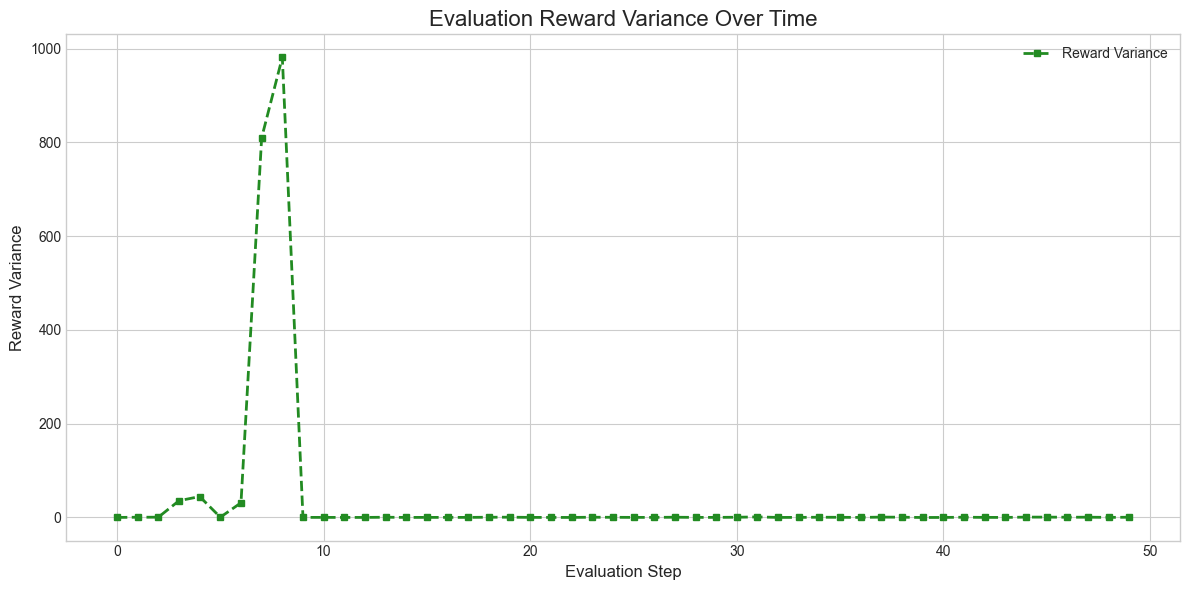

In [12]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...
print("--- Plotting Results for Q-Network Baseline Model ---")
plot_smoothed_training_rwd(train_reward_lst, window_size=20)

# plot_eval_rwd_mean(...
plot_eval_rwd_mean(eval_reward_mean_lst)

# plot_eval_rwd_var(...
plot_eval_rwd_var(eval_reward_var_lst)

# Q-Network - Alternative

In [ ]:
# 绘制 Q-Network Alternative 的结果
print("--- Plotting Results for Q-Network Alternative Model ---")
plot_smoothed_training_rwd(train_reward_lst_alt, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst_alt)
plot_eval_rwd_var(eval_reward_var_lst_alt)


In [ ]:
# 训练 Q-Network Alternative 模型
# For logging
train_reward_lst_alt = []
eval_reward_mean_lst_alt = []
eval_reward_var_lst_alt = []

# Set up environment
env_alt = gym.make("CartPole-v1")
state_size = env_alt.observation_space.shape[0]
action_size = env_alt.action_space.n

model_dir_alt = "q_net_alternative"  # TensorBoard log directory
cb_alt = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir_alt), histogram_freq=1)

# For timing training
total_training_time_alt = 0

# 重置 epsilon 用于 alternative 训练
epsilon_alt = 1.0

print("开始训练 Q-Network Alternative 模型...")

for ep in range(episode):
    state, _ = env_alt.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon_alt:
            action = np.random.choice(action_size)
        else:
            q_values = model_alt.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env_alt.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # Train model using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
        # 1. Compute target Q-values
        if done:
            target_q = reward
        else:
            next_q_values = model_alt.predict(next_state, verbose=0)[0]
            target_q = reward + gamma * np.max(next_q_values)
        
        # 2. Predict current Q-values for state
        q_values = model_alt.predict(state, verbose=0)[0]
        q_values[action] = target_q

        # 3. Fit the model
        model_alt.fit(state, q_values.reshape(1, -1), epochs=epoch, verbose=0)

        state = next_state
        total_reward += reward

        if done:
            break

    # record end time and log the training time
    end = time.time()
    total_training_time_alt += end - start
    
    # Update exploration rate (每个episode更新一次)
    if epsilon_alt > epsilon_min:
        epsilon_alt *= epsilon_decay

    # Evaluation
    eval_reward_mean, eval_reward_var = evaluation(model_alt, max_timesteps=500)

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon_alt:.3f}"
        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst_alt.append(eval_reward_mean)
    eval_reward_var_lst_alt.append(eval_reward_var)
    train_reward_lst_alt.append(total_reward)

    # Early Stopping Condition
    if eval_reward_mean > 500:
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# evaluate average training time per episode
print(f"Training time: {total_training_time_alt/(ep + 1):.4f} seconds per episode")

env_alt.close()


In [13]:
# Q-Network Alternative Model
# 使用更深的网络结构（3层隐藏层）和不同的学习率进行实验
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# 定义 Alternative Q-network（使用更深的网络）
model_alt = Sequential()

# 添加网络层：3层隐藏层，每层128个神经元
model_alt.add(Dense(128, input_dim=4, activation='relu'))  # 第一层隐藏层
model_alt.add(Dense(128, activation='relu'))                # 第二层隐藏层
model_alt.add(Dense(128, activation='relu'))                # 第三层隐藏层
model_alt.add(Dense(2, activation='linear'))                # 输出层：2个动作的Q值

# 编译模型：使用稍高的学习率
model_alt.compile(loss='mse', optimizer=Adam(learning_rate=lr * 2))  # 学习率是baseline的2倍

# 打印模型摘要
print("--- Q-Network Alternative Model ---")
model_alt.summary()


--- Q-Network Alternative Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,922 (132.51 KB)

 Trainable params: 33,922 (132.51 KB)

 Non-trainable params: 0 (0.00 B)

## Comparison

Compare performance of the Baseline and the Alternative Naive Q-Network policies

In [14]:
# [Write Code]

# Experience Replay Framework

By now, you may have noticed that in a standard RL setup, the agent **only learns from its most recent experience** at each step. This makes training unstable and inefficient. Additionally, consecutive experiences are often highly correlated, which can lead to poor generalization.

To address this, we will adopt the **Experience Replay Framework**, where past interactions are stored in a **Replay Buffer** and **a randomly sampled batch** is used to update the decision-making policy. This helps to:

- **Break correlation** between consecutive experiences, stabilizing learning.
- **Improve data efficiency** by reusing past experiences multiple times.
- **Smooth training updates**, preventing abrupt policy changes.

The figure below illustrates this process:
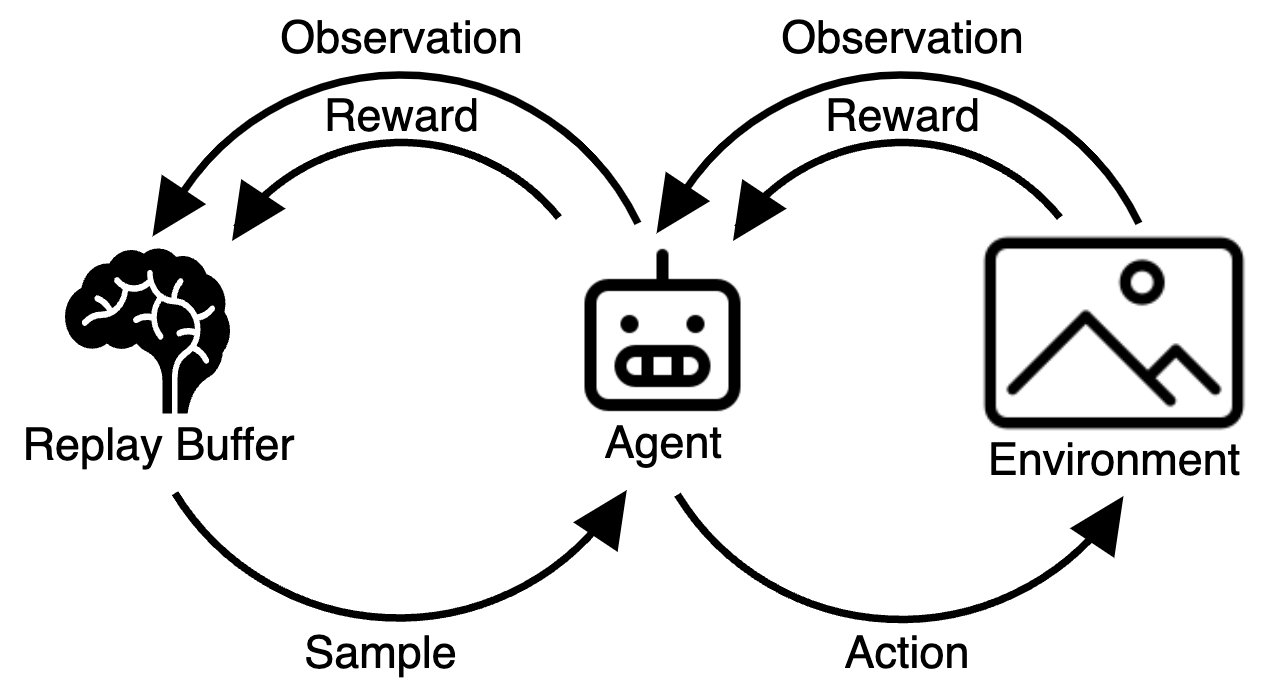

- The Agent interacts with the Environment, taking actions based on its learned policy.
- The Replay Buffer stores past experiences `(state, action, reward, next state, done)`.
- Instead of updating after every step, the agent samples from the buffer and learns from past interactions.

This framework is used in naive DQN, DQN and DDQN to stabilize Q-learning.



## Implement Replay Buffer and Functions

In [15]:
# Store (state, action, reward, next_state, done)
def store_experience(replay_buffer, state, action, reward, next_stat, done):
        replay_buffer.append((state, action, reward, next_state, done))

# Sample (state, action, reward, next_state, done) mini-batch for training
def sample_experience(replay_buffer, batch_size):

    # Ensure we have enough samples
    assert len(replay_buffer) >= batch_size, (
        f"Not enough samples in buffer to sample {batch_size} items.")

    # Sample a mini-batch
    minibatch = random.sample(replay_buffer, batch_size)

    states, actions, rewards, next_states, dones = zip(*minibatch)  #将数据按类别分开

    states = np.array(states, dtype=np.float32).squeeze()   #.squeeze() 用于移除数组中维度为 1 的轴
    next_states = np.array(next_states, dtype=np.float32).squeeze()
    actions = np.array(actions, dtype=np.int32)
    rewards = np.array(rewards, dtype=np.float32)
    dones = np.array(dones, dtype=np.float32)

    return states, actions, rewards, next_states, dones

# [Hint] You may find the following statements useful
"""
# Define replay buffer
replay_buffer = deque(maxlen=10000)

# Store experience tuple into replay_buffer
store_experience(replay_buffer, state, action, reward, next_state, done)

# Sample mini-batch of size ba from replay_buffer
states, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)
"""

'\n# Define replay buffer\nreplay_buffer = deque(maxlen=10000)\n\n# Store experience tuple into replay_buffer\nstore_experience(replay_buffer, state, action, reward, next_state, done)\n\n# Sample mini-batch of size ba from replay_buffer\nstates, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)\n'

# Naive DQN - Baseline

In this section, you will complete the Naive DQN alorithm by implementing the missing components marked as `[WriteCode]`.



## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

In [16]:
# Naive DQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the Q-network
model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]

## Set Up Env and Train the Policy

In [17]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "naive_dqn_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# For timing training
total_training_time = 0

# Define replay buffer
# [WriteCode]
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            pass # remove pass and use 2 lines below
#            q_values = model.predict(state, verbose=0)
#            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break


#        if len(replay_buffer) >= ba:
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
            # [WriteCode]

            # Hints:

            # 1. Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q(next_state, a))

            # 2. Predict current Q-values for state
            # Update only the Q-value for the taken action

            # 3. Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)

            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]


    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}")
#        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
#        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
#    eval_reward_mean_lst.append(eval_reward_mean)
#    eval_reward_var_lst.append(eval_reward_var)
#    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
#    if eval_reward_mean > 500: # [Modify this threshold as needed]
#        print(f"Early stopping triggered at Episode {ep + 1}.")
#        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

TensorBoard log directory: c:\Users\roycl\Desktop\EEC4400\eec4400_logs\naive_dqn_baseline\run_2025_11_06-16_14_50
Episode 1/50 | Ep. Total Reward: 21.0 | Epsilon : 0.778
Episode 2/50 | Ep. Total Reward: 26.0 | Epsilon : 0.778
Episode 3/50 | Ep. Total Reward: 25.0 | Epsilon : 0.778
Episode 4/50 | Ep. Total Reward: 19.0 | Epsilon : 0.778
Episode 5/50 | Ep. Total Reward: 15.0 | Epsilon : 0.778
Episode 6/50 | Ep. Total Reward: 12.0 | Epsilon : 0.778
Episode 7/50 | Ep. Total Reward: 24.0 | Epsilon : 0.778
Episode 8/50 | Ep. Total Reward: 13.0 | Epsilon : 0.778
Episode 9/50 | Ep. Total Reward: 16.0 | Epsilon : 0.778
Episode 10/50 | Ep. Total Reward: 15.0 | Epsilon : 0.778
Episode 11/50 | Ep. Total Reward: 12.0 | Epsilon : 0.778
Episode 12/50 | Ep. Total Reward: 21.0 | Epsilon : 0.778
Episode 13/50 | Ep. Total Reward: 22.0 | Epsilon : 0.778
Episode 14/50 | Ep. Total Reward: 13.0 | Epsilon : 0.778
Episode 15/50 | Ep. Total Reward: 18.0 | Epsilon : 0.778
Episode 16/50 | Ep. Total Reward: 15.0 |

## Plot Results

In [18]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...


# Naive DQN - Alternative
You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

In [19]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative Naive DQN Policies

In [20]:
# [Write Code]

# DQN

In this section, you will complete the DQN algorithm by implementing the missing components marked as `[WriteCode]`.


## Define and Compile the Neural Networks

The standard DQN [https://arxiv.org/abs/1312.5602] approach features a periodically updated target network to stabilize training:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is not actively trained, but at regular intervals, its weights are copied from `eval_model`. This prevents rapid fluctuations in target Q-values and improves learning stability.

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to compute $Q(S_{t}, a)$ for each possible action $a$. It updates its weights by minimizing the difference between predicted and target Q-values, improving the agent's decision-making over time.

The target used by DQN is then:

$Y^{Q}_t = R_{t+1} + \gamma \max_a Q_{target}(S_{t+1}, a)$

In the following section, define `[eval_model]` and `[target_model]` with identical architectures.

In [21]:
# DQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the eval (online) network
eval_model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]


# Create target_model with the same architecture
target_model = Sequential()

# [WriteCode]
# model.add(...

# Skip compiling as target_model will not be trained with .fit()
# Instead, weights will be copied from the online model
target_model.set_weights(eval_model.get_weights())

# Print the model summary
# [WriteCode]
print(target_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Set Up Env and Train the Policy

In this section, you will complete the DQN training routine by implementing the missing components marked as `[WriteCode]`.




In [22]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "dqn_baseline"   # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# Train Counter for weight syncing
train_counter = 0

# For timing training
total_training_time = 0

# Define replay buffer
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            pass # remove pass and 2 lines below
#            q_values = eval_model.predict(state, verbose=0)
#            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break

        # if len(replay_buffer) >= ba:
            # train_counter += 1
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Deep Q-Learning update: Q(s, a) = r + gamma * max Q_target(S', a)
            # [WriteCode]

            # Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q_target(next_state, a))

            # Predict current Q-values for state using eval_model
            # Predict future Q-values using target_model (NOT eval_model)

            # Update only the Q-value for the taken action

            # Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)


            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Periodically update the target network
            if train_counter % target_update_freq == 0:
                target_model.set_weights(eval_model.get_weights())

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}")
#        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
#        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
#    eval_reward_mean_lst.append(eval_reward_mean)
#    eval_reward_var_lst.append(eval_reward_var)
#    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
#    if eval_reward_mean > 500: # [Modify this threshold as needed]
#        print(f"Early stopping triggered at Episode {ep + 1}.")
#        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

TensorBoard log directory: c:\Users\roycl\Desktop\EEC4400\eec4400_logs\dqn_baseline\run_2025_11_06-16_14_50
Episode 1/50 | Ep. Total Reward: 9.0 | Epsilon : 0.778
Episode 2/50 | Ep. Total Reward: 11.0 | Epsilon : 0.778
Episode 3/50 | Ep. Total Reward: 13.0 | Epsilon : 0.778
Episode 4/50 | Ep. Total Reward: 37.0 | Epsilon : 0.778
Episode 5/50 | Ep. Total Reward: 31.0 | Epsilon : 0.778
Episode 6/50 | Ep. Total Reward: 33.0 | Epsilon : 0.778
Episode 7/50 | Ep. Total Reward: 11.0 | Epsilon : 0.778
Episode 8/50 | Ep. Total Reward: 11.0 | Epsilon : 0.778
Episode 9/50 | Ep. Total Reward: 9.0 | Epsilon : 0.778
Episode 10/50 | Ep. Total Reward: 15.0 | Epsilon : 0.778
Episode 11/50 | Ep. Total Reward: 31.0 | Epsilon : 0.778
Episode 12/50 | Ep. Total Reward: 38.0 | Epsilon : 0.778
Episode 13/50 | Ep. Total Reward: 12.0 | Epsilon : 0.778
Episode 14/50 | Ep. Total Reward: 13.0 | Epsilon : 0.778
Episode 15/50 | Ep. Total Reward: 13.0 | Epsilon : 0.778
Episode 16/50 | Ep. Total Reward: 34.0 | Epsilon

## Plot Results

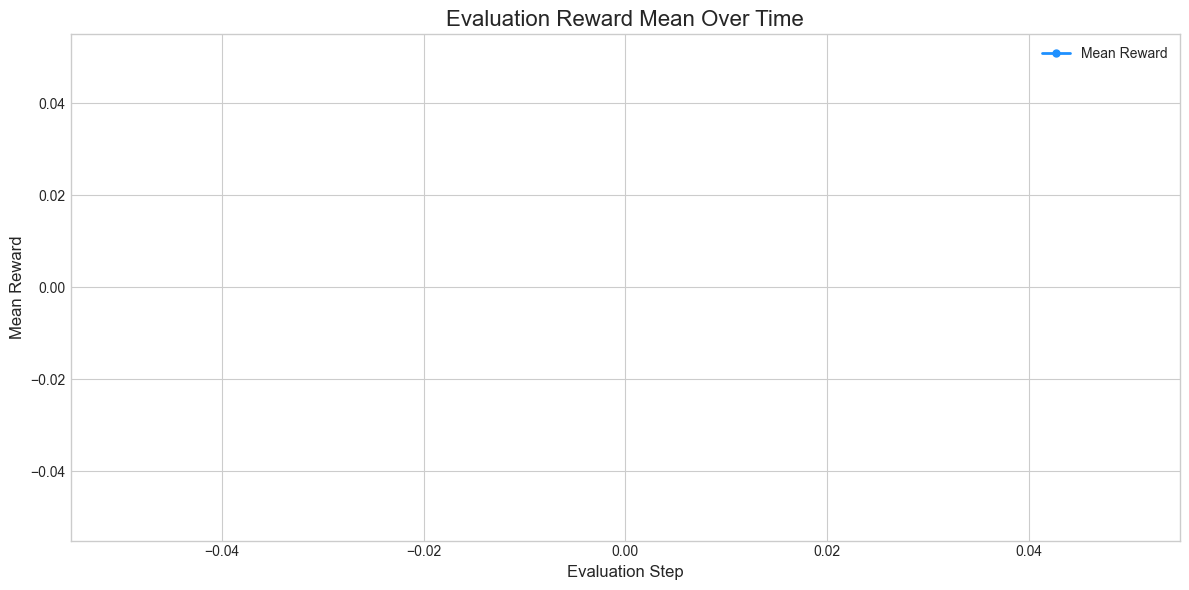

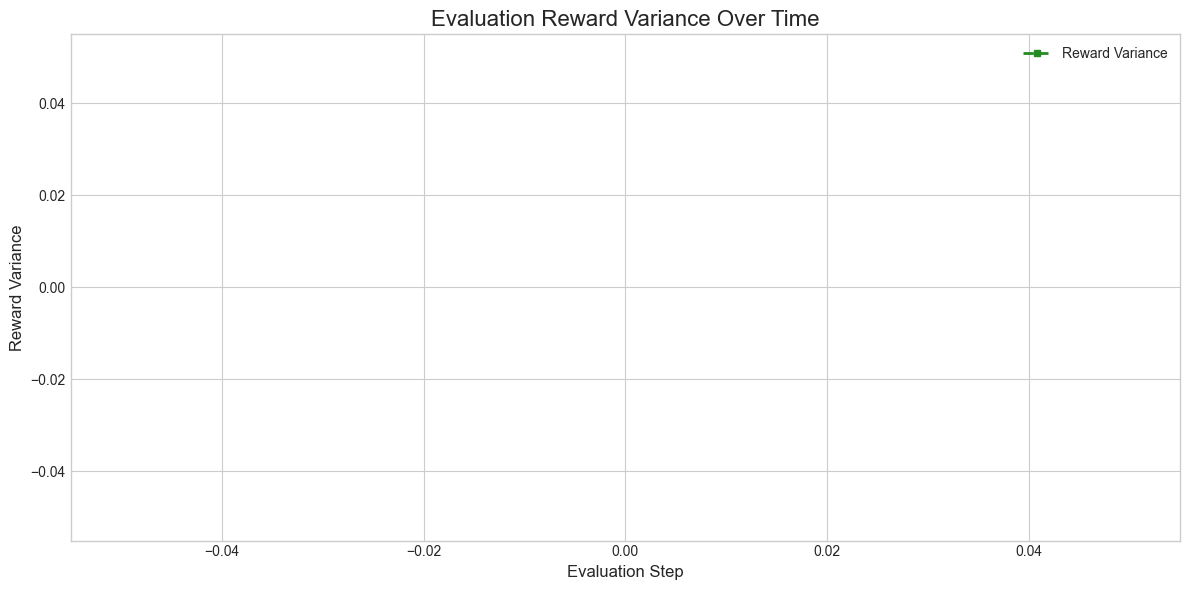

In [23]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]
plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

# DQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

## Plot Results

In [24]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...

In [25]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative DQN Policies

In [26]:
# [Write Code]

# DDQN

## Define and Compile the Neural Networks

The Double Deep Q-Network (DDQN) [https://arxiv.org/abs/1509.06461] improves upon standard DQN by reducing overestimation bias in Q-values. DDQN achieves this by decoupling action selection from value estimation using two networks, which is almost identical as DQN:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is also not trained but synced from `eval_model`. **However, unlike DQN, this network is only used to evaluate the Q-value of the action chosen by `eval_model`, making value updates more stable.**

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to select the best action using $\arg\max_a Q(S_{t}, a)$ and updates its weights by minimizing the difference between predicted and target Q-value.

The target used by DDQN is then:

$Y^{Q}_t = R_{t+1} + \gamma Q_{target}(S_{t+1}, \arg \max_{a} Q_{eval}(S_{t+1}, a))$

In [27]:
# DDQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...
import os
import time
import numpy as np
import random
import gymnasium as gym
from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam 



# Define the eval (online) network
eval_model = Sequential()

# [WriteCode]
# model.add(...
eval_model.add(Dense(64, input_dim=4, activation='relu')) # 输入层 + 第一个隐藏层
eval_model.add(Dense(64, activation='relu'))      # 第二个隐藏层
eval_model.add(Dense(64, activation='relu'))           # 第三个隐藏层    
eval_model.add(Dense(2, activation='linear'))           # 输出层，输出每个动作的Q值
# Compile the model
# [WriteCode]
eval_model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
# Print the model summary
# [WriteCode]
print("--- Evaluation Model (Online Network) ---")
eval_model.summary()

# Create target_model with the same architecture
target_model = Sequential()

# [WriteCode]
# model.add(...
target_model.add(Dense(64, input_dim=4, activation='relu')) # 输入层 + 第一个隐藏层
target_model.add(Dense(64, activation='relu'))      # 第二个隐藏层
target_model.add(Dense(64, activation='relu'))           # 第三个隐藏层    
target_model.add(Dense(2, activation='linear'))           # 输出层，输出每个动作的Q值
# Skip compiling as target_model will not be trained with .fit()
# Instead, weights will be copied from the online model
# target_model.set_weights(eval_model.get_weights())

# Print the model summary
# [WriteCode]
print("\n--- Target Model ---")
target_model.summary()

--- Evaluation Model (Online Network) ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,770 (34.26 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)


--- Target Model ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,770 (34.26 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Use the following set of NN hyperparameters for ALL FOUR baseline policies
lr =  0.00025        #@param {type:"number"}               # learning rate
epochs =  1     #@param {type:"number"}               # epochs
episode = 250  #@param {type:"number"}               # episodes

epsilon = 1           #@param {type:"number"}     # Starting exploration rate
epsilon_min = 0.01    #@param {type:"number"}     # Exploration rate min
epsilon_decay = 0.995     #@param {type:"number"}     # Exploration rate decay

gamma = 0.99          #@param {type:"number"}     # Agent discount factor

# Use the following set of NN hyperparameters for Naive DQN, DQN and DDQN policies
ba =  32       #@param {type:"number"}               # batch_size

# Use the following set of RL hyperparameters for DQN and DDQN policies
target_update_freq = 100 # @param {type:"number"}    # Target network update frequency

## Set Up Env and Train the Policy

In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "ddqn_baseline"  # TensorBoard log directory
#cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)
# 【新代码】手动创建 TensorBoard 的 summary writer
logdir = get_run_logdir(model_dir)
summary_writer = tf.summary.create_file_writer(logdir + "/train")


# Train Counter for weight syncing
train_counter = 0

# For timing training
total_training_time = 0

# Define replay buffer
replay_buffer = deque(maxlen=10000)

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):

        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            #pass # remove pass and use 2 lines below
            q_values = eval_model.predict(state, verbose=0)
            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]
        store_experience(replay_buffer, state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if done:
            break

        if len(replay_buffer) >= ba:
            train_counter += 1
            states, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)

            #下面几行是在构造训练目标标签
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Double Deep Q-Learning update:
            # Q(s, a) = r + gamma * Q_target(S', argmax Q_eval(S', a))
            # [WriteCode]
            q_next_eval = eval_model.predict(next_states, verbose=0) # Shape: (batch_size, action_size)
            best_actions_next = np.argmax(q_next_eval, axis=1) # Shape: (batch_size,)
            q_next_target = target_model.predict(next_states, verbose=0)
            target_q_for_actions = q_next_target[range(ba), best_actions_next]  # Shape: (batch_size,)
            # Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * Q_target(S', argmax Q_eval(S', a))
            target_q_values = rewards + (gamma * target_q_for_actions * (1 - dones))

            # Predict current Q-values for state using eval_model
            # Use eval_model to determine best action in next_state
            # Use target_model to compute Q-value for that action
            current_q_values = eval_model.predict(states, verbose=0)
            target_for_fit = current_q_values
            
            # Update only the Q-value for the taken action
            target_for_fit[range(ba), actions] = target_q_values

            #目标标签构建好，将训练输入和目标传入fit函数中进行训练
            # Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)
            history = eval_model.fit(states, target_for_fit, epochs=1, verbose=0)  #这里训练一个epoch，其实就是上面那一个batch  # 不再需要 callbacks=[cb]
            # Update exploration rate
            # 【新代码】手动记录损失值
            loss = history.history['loss'][0]  # 从 history 对象中获取损失值

            # 【修改后代码】在这里记录 Loss 和 Average Q-Value
            # 计算当前批次状态的平均最大Q值
            avg_max_q = np.mean(np.max(current_q_values, axis=1))
            with summary_writer.as_default():
                tf.summary.scalar('batch_loss', data=loss, step=train_counter)
                tf.summary.scalar('average_max_q_value', data=avg_max_q, step=train_counter)

            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Periodically update the target network
            if train_counter % target_update_freq == 0:
               target_model.set_weights(eval_model.get_weights())

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]
    eval_reward_mean, eval_reward_var = evaluation(eval_model, max_timesteps=500)

    # 【修改后代码】在这里记录 Evaluation Reward
    with summary_writer.as_default():
        # 我们使用 episode 数量作为 x 轴，因为它在每个 episode 结束时才计算
        tf.summary.scalar('evaluation_reward_mean', data=eval_reward_mean, step=ep)
        # 也可以记录训练时的奖励，但评估奖励更具代表性
        tf.summary.scalar('training_episode_reward', data=total_reward, step=ep)

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}"
        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
    if eval_reward_mean > 500: # [Modify this threshold as needed]
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# record end time and calculate average training time per episode
# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

TensorBoard log directory: c:\Users\roycl\Desktop\EEC4400\eec4400_logs\ddqn_baseline\run_2025_11_06-16_14_51
Episode 1/250 | Ep. Total Reward: 28.0 | Epsilon : 1.000 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.64
Episode 2/250 | Ep. Total Reward: 15.0 | Epsilon : 0.946 | Eval Rwd Mean: 50.60 | Eval Rwd Var: 63.04
Episode 3/250 | Ep. Total Reward: 14.0 | Epsilon : 0.887 | Eval Rwd Mean: 9.20 | Eval Rwd Var: 0.56
Episode 4/250 | Ep. Total Reward: 49.0 | Epsilon : 0.697 | Eval Rwd Mean: 9.00 | Eval Rwd Var: 0.40
Episode 5/250 | Ep. Total Reward: 11.0 | Epsilon : 0.663 | Eval Rwd Mean: 10.00 | Eval Rwd Var: 0.40
Episode 6/250 | Ep. Total Reward: 12.0 | Epsilon : 0.627 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.24
Episode 7/250 | Ep. Total Reward: 20.0 | Epsilon : 0.570 | Eval Rwd Mean: 9.40 | Eval Rwd Var: 0.24
Episode 8/250 | Ep. Total Reward: 12.0 | Epsilon : 0.540 | Eval Rwd Mean: 9.20 | Eval Rwd Var: 0.56
Episode 9/250 | Ep. Total Reward: 9.0 | Epsilon : 0.519 | Eval Rwd Mean: 9.40 | Eval Rwd

## Plot Results

--- Plotting Results for DDQN Baseline Model ---


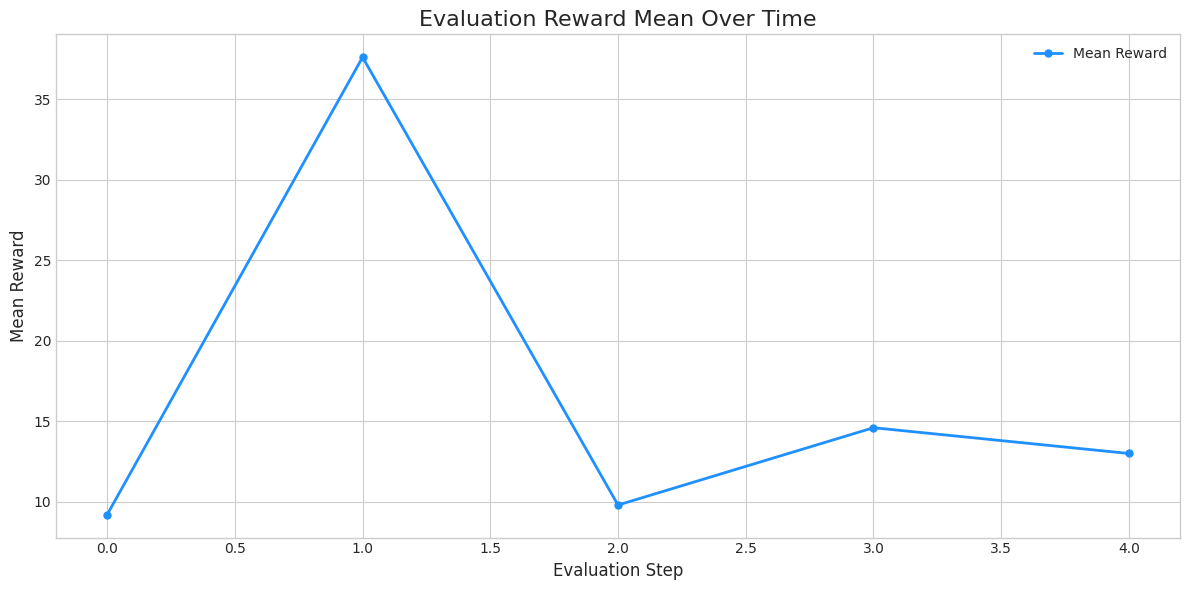

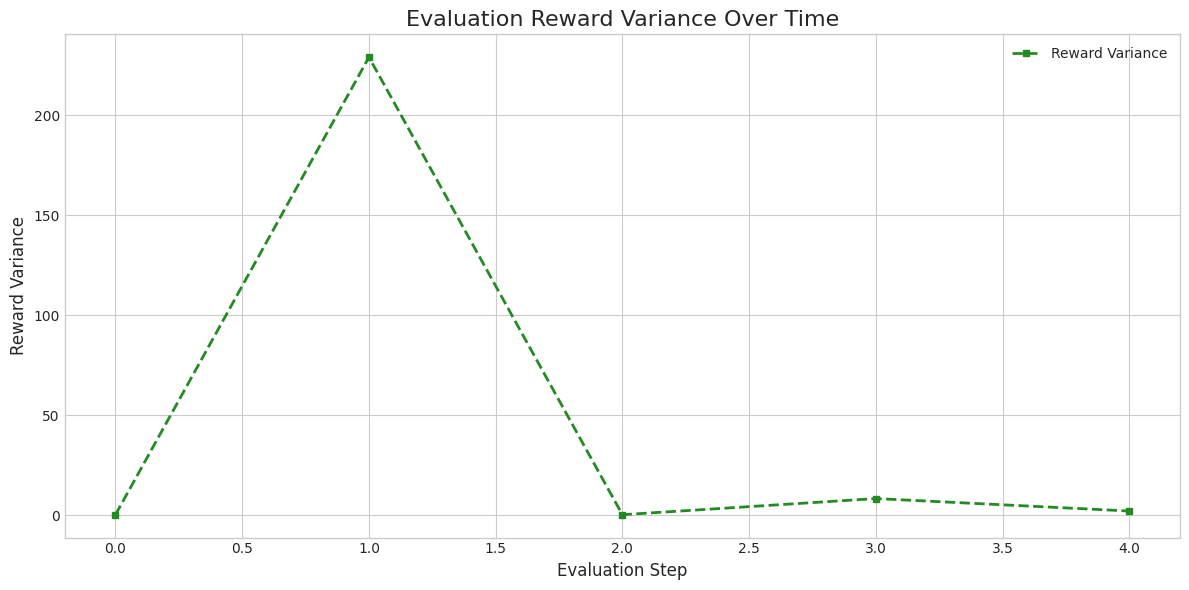

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]
print("--- Plotting Results for DDQN Baseline Model ---")
plot_smoothed_training_rwd(train_reward_lst, window_size=20)

plot_eval_rwd_mean(eval_reward_mean_lst)

plot_eval_rwd_var(eval_reward_var_lst)

# DDQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative DDQN Policies

In [ ]:
# [Write Code]

# Visualize with Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./eec4400_logs --port=6006

# Comparison Across Four Alternative Policies

Compare hyperparameters and performance of the four alternative policies.

You may insert extra cells in the notebook to tabulate/plot/log results effectively.

In [ ]:
# [Write Code]